# Аналитика в Яндекс.Афише

Помочь маркетологам оптимизировать маркетинговые затраты.

У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.


## Описание данных

Таблица `visits` (лог сервера с информацией о посещениях сайта):

- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица `orders` (информация о заказах):

- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица `costs` (информация о затратах на маркетинг):

- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

### Шаг 1. Загрузить данные и подготовить их к анализу.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [2]:
visits_data = pd.read_csv('/datasets/visits_log.csv')
orders_data = pd.read_csv('/datasets/orders_log.csv')
costs_data = pd.read_csv('/datasets/costs.csv')

Мы импортировали cvs файлы, нужные нам библиотеки и метод `display` для вывода на печать таблиц.

In [3]:
display(visits_data.head(10))
visits_data.info()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
display(orders_data.head(10))
orders_data.info()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [5]:
display(costs_data.head(10))
costs_data.info()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [6]:
# преобразуем названия столбцов к нижнему регистру
visits_data.columns = visits_data.columns.str.lower()
orders_data.columns = orders_data.columns.str.lower()


In [7]:
# переименуем столбцы
visits_data.rename(columns={'end ts': 'end_ts', 'source id': 'source_id', 'start ts': 'start_ts'}, inplace=True)
orders_data.rename(columns={'buy ts': 'buy_ts',}, inplace=True)

In [8]:
# поменяем тип данных в столбцах. 
visits_data['end_ts'] = pd.to_datetime(visits_data['end_ts'])
visits_data['start_ts'] = pd.to_datetime(visits_data['start_ts'])
orders_data['buy_ts'] = pd.to_datetime(orders_data['buy_ts'])
costs_data['dt'] = pd.to_datetime(costs_data['dt'])

In [9]:
#Проверяем как все сработало
visits_data.info()
orders_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


### Вывод

Мы имеем три таблицы с разным количеством строк и столбцов. Пропуска в таблицах отсутствуют, есть небольшие замечания в типах данных в столбцах с датами. Мы поменяли тип данных с помощью метода `pd.to_datetime`. Также мы изменили наименования столбцов - привели к нижнему регистру и добавили нижнее подчеркивание вместо пробелов. Это позволит избежать опечаток и быстрее писать последующий код. Для дальнейшего анализа, расчетов метрик и визуализации все столбцы несут свою определенную ценность.

### Шаг 2. Построить отчёты и посчитать метрики.

#### Шаг 2.1. Количество людей, использующих продукт в день, неделю, месяц.

In [10]:
# Узнаем какие есть утройства. 
visits_data['device'].unique()

array(['touch', 'desktop'], dtype=object)

Пользователи пользуются сервисом с помощью мобильный телефонов или ПК. 

In [11]:
# Узнаем какие есть рекламные источники.
visits_data['source_id'].unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

Есть все источники от первого до десятого, кроме восьмого.

In [12]:
visits_data['session_year'] = visits_data['start_ts'].dt.year
visits_data['session_month'] = visits_data['start_ts'].dt.month
visits_data['session_week'] = visits_data['start_ts'].dt.week
visits_data['session_date'] = visits_data['start_ts'].dt.date

Выделили в отдельные столбцы год, месяц и неделю, а также полную дату посещения сайта клиентами. 

In [13]:
#Cоздадим срезы по каждому устройсву 
visits_data_touch = visits_data.query('device == "touch"')
visits_data_desktop = visits_data.query('device == "desktop"')

In [14]:
dau_mean_touch = visits_data_touch.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_mean_touch = visits_data_touch.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_mean_touch = visits_data_touch.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()

print("Источник - мобильное устройство:")
print("Среднее кол-во пользователей в день:", int(dau_mean_touch))
print("Среднее кол-во пользователей в неделю:", int(wau_mean_touch))
print("Среднее кол-во пользователей в месяц:", int(mau_mean_touch))

Источник - мобильное устройство:
Среднее кол-во пользователей в день: 252
Среднее кол-во пользователей в неделю: 1634
Среднее кол-во пользователей в месяц: 6825


In [15]:
dau_mean_desktop = visits_data_desktop.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_mean_desktop = visits_data_desktop.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_mean_desktop = visits_data_desktop.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()

print("Источник - персональный компьютер:")
print("Среднее кол-во пользователей в день:", int(dau_mean_desktop))
print("Среднее кол-во пользователей в неделю:", int(wau_mean_desktop))
print("Среднее кол-во пользователей в месяц:", int(mau_mean_desktop))

Источник - персональный компьютер:
Среднее кол-во пользователей в день: 659
Среднее кол-во пользователей в неделю: 4129
Среднее кол-во пользователей в месяц: 16724


In [16]:
# Построем сводную таблицу для анализа кол-ва посещений с разных усттройств по месяцам
mau_total = visits_data.pivot_table(index = ['session_year', 'session_month'],\
                                                                          columns = ['device'], values = 'uid', \
                                                                          aggfunc = 'nunique')

display(mau_total)

device                      desktop  touch
session_year session_month                
2017         6                 9761   3655
             7                10145   4223
             8                 8611   3132
             9                13509   5679
             10               21286   8856
             11               24439   8913
             12               23294   8785
2018         1                20350   8741
             2                20574   8590
             3                19574   8303
             4                14844   6387
             5                14312   6647

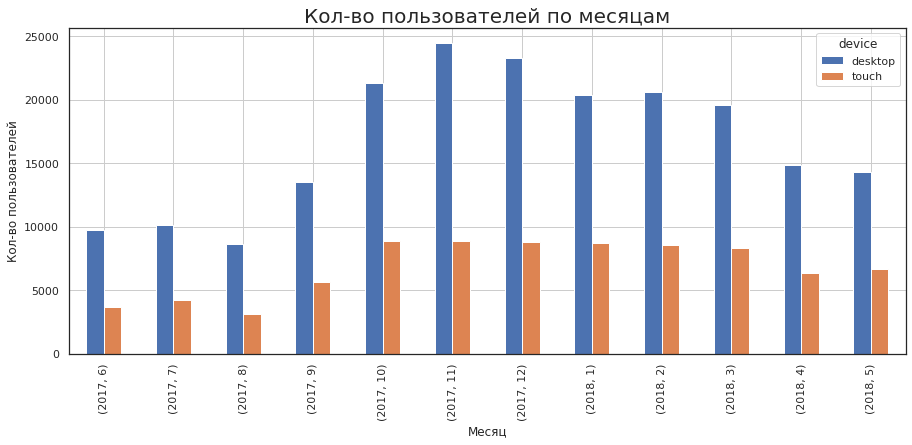

In [69]:
mau_total.plot(kind='bar', figsize=(15,6), grid=True)
plt.title("Кол-во пользователей по месяцам", fontsize = 20)
plt.xlabel("Месяц", fontsize = 12)
plt.ylabel("Кол-во пользователей", fontsize = 12)
plt.show()

In [18]:
# Построем сводную таблицу для анализа кол-ва посещений с разных источников по месяцам
wau_total_source = visits_data.pivot_table(index = ['session_year', 'session_week'],\
                                                                          columns = ['source_id'], values = 'uid', \
                                                                          aggfunc = 'nunique', fill_value=0)

display(wau_total_source.head(15))

source_id                   1    2     3     4     5   6   7    9    10
session_year session_week                                              
2017         22            163  259   614   510   415   0   0  102   65
             23            342  525  1423   998   825   0   1  171  169
             24            206  390   834   900   395   0   0  129   95
             25            205  339   800   784   674   0   1  165   70
             26            232  354   804   718   848   1   0  241   60
             27            239  404   954   994   706   0   1  146   67
             28            304  543  1163  1421  1029   0   0   98   87
             29            336  551  1063   957   967   0   0  178   99
             30            202  349   696   605   795   0   1  116   51
             31            179  309   653   651   552   0   0  139   25
             32            165  272   721   618   628   0   0  133   39
             33            212  325   684   669   771   0   1  165   58
             34            212  371   872   793   857   0   0  134   59
             35            281  442  1146   951   871   1   0  166   98
             36            303  539  1273  1133  1063   1   0  307  105

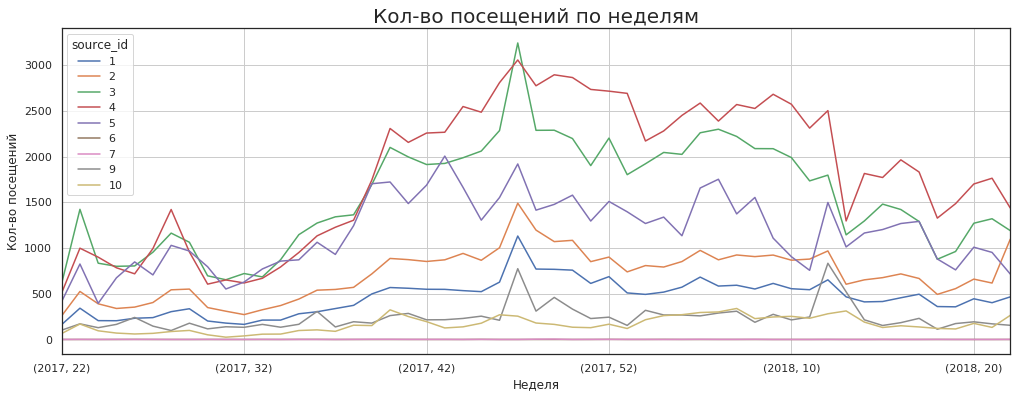

In [70]:
wau_total_source.plot(figsize=(17,6), grid=True)
plt.title("Кол-во посещений по неделям", fontsize = 20)
plt.xlabel("Неделя", fontsize = 12)
plt.ylabel("Кол-во посещений", fontsize = 12)
plt.show()

### Вывод

Люди чаще пользуются сервисом Яндекс Афиша через компьютер, чем не через телефон, примерно в 2.5 раза. Это наблюдается по всем показателям DAU, WAU, MAU и по графику. Если смотреть на динамику кол-ва пользователей по месяцам, то виден рост в холодное время года. Как раз начинается сезон театров, хочется меньше проводить время в холодную погоду на улице. Летом спад - в приоритете сезон отпусков, прогулки на свежем воздухе. 

Что касается рекламных источников, то явный лидер источник № 3 и 4, показывают высокую динамику, поочередно отбирая у друг друга почетное первое место. Источник №6 и 7 совершенно не работают, находится на пограничном уровне около нуля посещений.


#### Шаг 2.2. Количество сессий в день.

In [20]:
session_day_total = visits_data.pivot_table(index = ['session_date'], columns = ['device'], values = 'uid', \
                                                                          aggfunc = 'count')
display(session_day_total)

device,desktop,touch
session_date,,
2017-06-01,501.0,163.0
2017-06-02,498.0,160.0
2017-06-03,329.0,148.0
2017-06-04,349.0,161.0
2017-06-05,693.0,200.0
...,...,...
2018-05-27,426.0,246.0
2018-05-28,835.0,321.0
2018-05-29,751.0,284.0


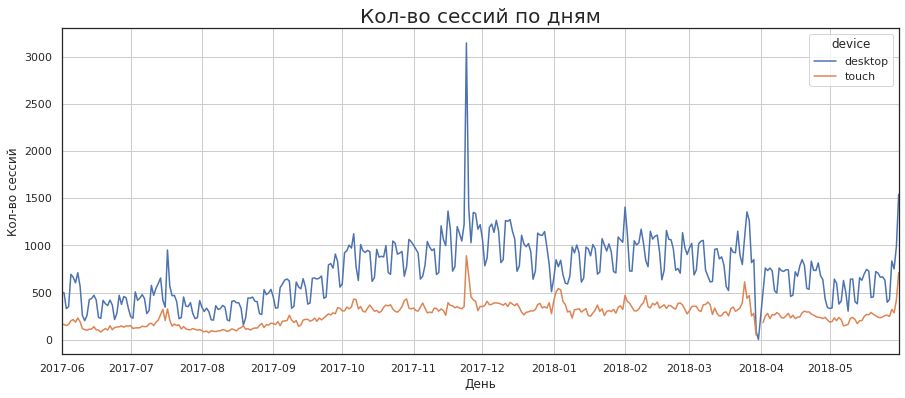

In [71]:
session_day_total.plot(figsize=(15,6), grid=True)
plt.title("Кол-во сессий по дням", fontsize = 20)
plt.xlabel("День", fontsize = 12)
plt.ylabel("Кол-во сессий", fontsize = 12)
plt.show()

In [22]:
session_day_desktop = visits_data_desktop.groupby('session_date').agg({'uid': 'count'}).mean()
session_day_touch = visits_data_touch.groupby('session_date').agg({'uid': 'count'}).mean()

print("Среднее кол-во сессий в день с компьютера:", int(session_day_desktop))
print("Среднее кол-во сессий в день с телефона:", int(session_day_touch))


Среднее кол-во сессий в день с компьютера: 721
Среднее кол-во сессий в день с телефона: 266


In [23]:
uid_session = visits_data.groupby(['session_date','uid']).agg({'uid': 'count'})
display(uid_session.head(10))
print('Cреднне кол-во сессий на одного пользователя в день:', uid_session['uid'].mean().round(2))

uid
session_date uid                    
2017-06-01   32197920403662046     1
             184148767273119549    2
             254239507810036143    1
             258099436367309303    1
             300776506671194537    1
             321069768889378113    1
             374683301246067167    1
             385619727271643289    1
             397723557959664980    1
             461906529430190072    1

Cреднне кол-во сессий на одного пользователя в день: 1.09


### Вывод

Во второй середине ноября 2017 года виден сильный рост в кол-ве сессий. Возможно была супер долгожданная премьера концерта, а возможно напротив - выбросы в данных. Нужен более глубокий анализ, чтобы это выяснить. 

Так на графике видна планомерная динамика, которая дублирует динамику уникальных пользователей. Среднее число сессий в день с компьютера по-прежнему в 2-3 раза больше чем с телефона.

В среднем один пользователей заходит на сайт по одному разу, несколько раз в редких случаях. 

#### Шаг 2.3. Продолжительность одной сессии.

In [24]:
visits_data['session_duration_sec'] = (visits_data['end_ts'] - visits_data['start_ts']).dt.seconds

print(visits_data['session_duration_sec'].mean())

643.506488592098


Мы посчитали длину всех сессий и вычислили среднее.

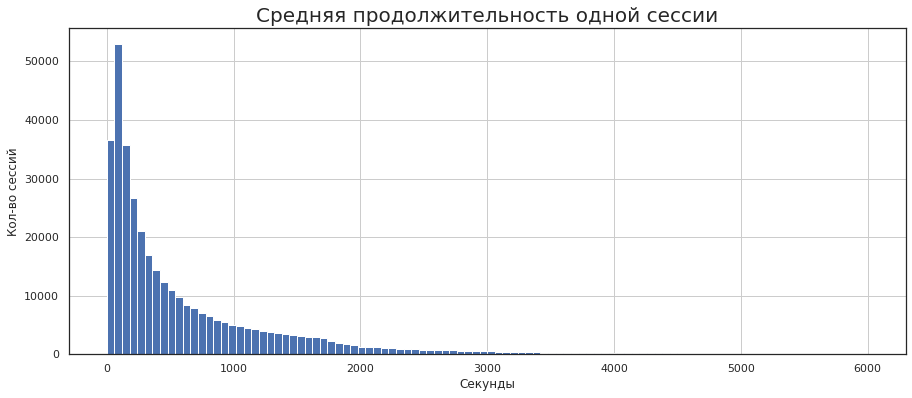

In [72]:
visits_data['session_duration_sec'].hist(bins=100, range=(0,6000), figsize=(15,6)) 
plt.title("Средняя продолжительность одной сессии", fontsize = 20)
plt.xlabel("Секунды", fontsize = 12)
plt.ylabel("Кол-во сессий", fontsize = 12)
plt.show()

Мы посмотрели на распределение длительности сессий. Длина сессий распределена неравномерно, значит среднее значение нам не подходит. Будем считать моду.

In [26]:
asl = visits_data['session_duration_sec'].mode()
print(asl)


0    60
dtype: int64


In [27]:
#Расчитаем также медиану
asl_median = visits_data['session_duration_sec'].median()
print(asl_median)

300.0


### Вывод

Обычно пользователи проводят на сайте Яндекс. Афиша 60 секунд. Это значение в выборке, которое встречается чаще всего. Число неоднозначное. Возможно сервис быстро и понятно работает для пользователей, и они успевают совершить свои покупки билетов или посмотреть ближайшие премьеры. Но возможно, что есть какие-то неполадки в сервисе и пользователи уходят раньше времени.

#### Шаг 2.4. Как часто люди возвращаются?

In [28]:
first_session_data = visits_data.groupby('uid')['start_ts'].min() 
first_session_data.name = 'first_session'
visits_data = visits_data.join(first_session_data, on='uid')

Узнали, когда пользователь впервые проявил активность в Яндекс.Афише. Переименовали имя Series и объединили с таблицей.

In [29]:
visits_data['visits_month'] = visits_data['start_ts'].astype('datetime64[M]')
visits_data['first_session_month'] = visits_data['first_session'].astype('datetime64[M]')

Мы выделили из столбцов месяцы.

In [30]:
visits_data['cohort_lifetime'] = visits_data['visits_month'] - visits_data['first_session_month']
visits_data['cohort_lifetime'] = (visits_data['cohort_lifetime'] / np.timedelta64(1,'M')).round().astype('int')

Рассчитали lifetime пользователя в рамках когорты. Из месяца совершения заказа вычли месяц когорты.

In [31]:
cohorts = visits_data.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 
display(cohorts.head(10))

,first_session_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
5,2017-06-01,5,947
6,2017-06-01,6,809
7,2017-06-01,7,766
8,2017-06-01,8,694
9,2017-06-01,9,674


Сгруппировали данные по когорте и lifetime. Посчитали для каждой когорты количество активных пользователей на определённую «неделю жизни».

In [32]:
initial_uid_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month','uid']]
initial_uid_count = initial_uid_count.rename(columns={'uid':'cohort_uid'}) 
display(initial_uid_count) 

,first_session_month,cohort_uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Нашли исходное количество пользователей в когорте. Взяли их число на нулевую неделю. Также переименовали столбец, что бы при последующем объединение не было одинаковых названий. 

In [33]:
cohorts = cohorts.merge(initial_uid_count,on='first_session_month') 

cohorts['retention'] = cohorts['uid']/cohorts['cohort_uid'] 

retention_pivot = cohorts.pivot_table(index='first_session_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
display(retention_pivot)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Объединили данные по когортам с исходным количеством пользователей в когорте. Рассчитали Retention Rate и построили сводную таблицу.

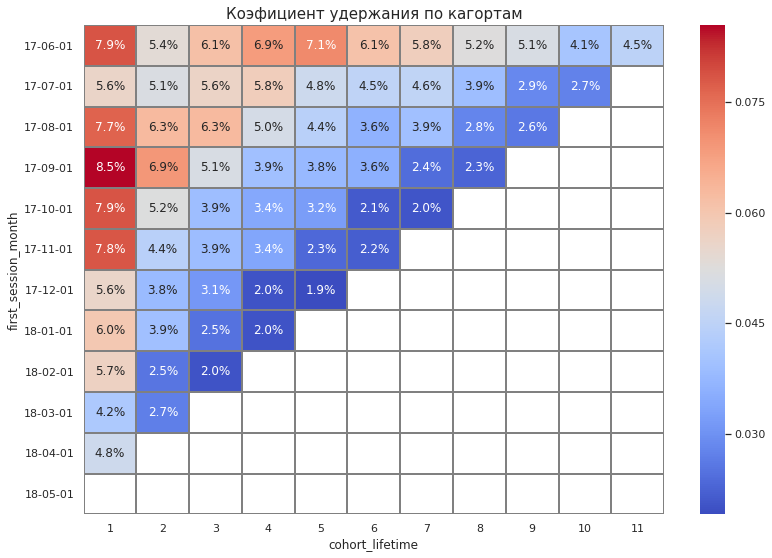

In [73]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Коэфициент удержания по кагортам', fontsize = 15)
sns.heatmap(retention_pivot[range(1,12)], annot=True, fmt='.1%', linewidths=1, linecolor='gray',\
            cmap = 'coolwarm', yticklabels=retention_pivot.index.strftime('%y-%m-%d'))
plt.show()

### Вывод

Retention Rate показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды. На тепловой карте наглядно видно, что число пользователей убывает по когортам с течением времени. Только в первой когорте начиная с 3-5 месяца виден небольшой прирост людей, пришедших впервые в эту когорту в июне. 

Каждый последующий месяц, после первого, в когортах показывает плавный спад вернувшихся пользователей. Возможно, были выбраны неэффективные источники привлечения клиентов или ухудшилось качество работы службы поддержки или люди не так часто ходят на концерты или в театры и вернуться через год. 


#### Шаг 2.5. Когда люди начинают покупать?

In [35]:
#Добавим к заказам дату первого посещений
orders_data_first_visits = orders_data.join(first_session_data, on='uid')
display(orders_data_first_visits)

,buy_ts,revenue,uid,first_session
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00
...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00


In [36]:
#узнаем дату первой покупки
first_buy = orders_data_first_visits.groupby('uid').agg({'buy_ts':'min'}).reset_index()
first_buy = first_buy.rename(columns={'buy_ts':'first_buy'}) 

#Добавим дату первой покупки в таблицу
orders_data = orders_data_first_visits.merge(first_buy, on='uid')
display(orders_data)

,buy_ts,revenue,uid,first_session,first_buy
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,2018-05-31 23:50:00
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,2018-05-31 23:50:00
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,2018-05-31 23:54:00
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2017-10-23 12:32:00,2018-05-31 23:56:00


In [37]:
#Посчитаем дельту между первой покупкой и посещением
orders_data['first_buy_sec'] = (orders_data['first_buy'] - orders_data['first_session']).dt.seconds

print(orders_data['first_buy_sec'].median())

1200.0


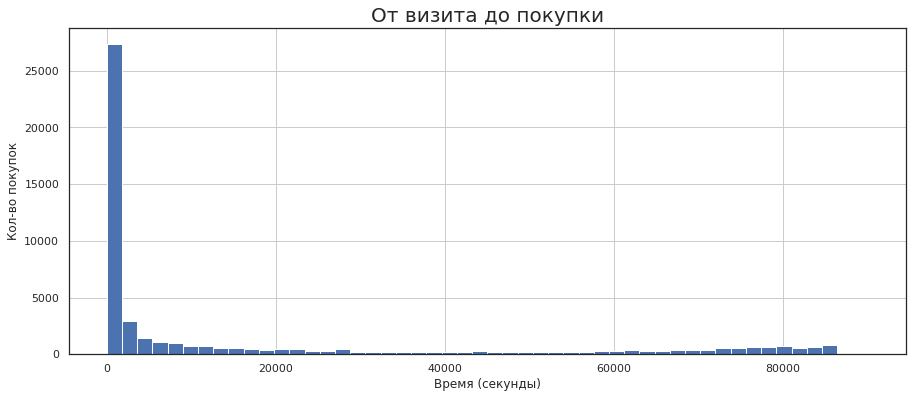

In [38]:
orders_data['first_buy_sec'].hist(bins=50, range=(0,90000), figsize=(15,6)) 
plt.title("От визита до покупки", fontsize = 20)
plt.xlabel("Время (секунды)", fontsize = 12,)
plt.ylabel("Кол-во покупок", fontsize = 12)
plt.show()

### Вывод

После первого посещения сайта, люди обычно возвращаются к покупке спустя 1200 секунд - Это 20 минут. Время вполне себе нормальное. Посмотрели афишу, по выбирали, обдумали и приступили к покупке.

#### Шаг 2.6. Количество покупок за период.

In [39]:
#Определим истоник каждого пользователя
sources = visits_data.sort_values(by =['uid','start_ts']).groupby('uid').agg({'source_id':'first'})
display(sources.head(7))

,source_id
uid,
11863502262781,3
49537067089222,2
297729379853735,3
313578113262317,2
325320750514679,5
397399764396656,4
407573351275847,2


In [40]:
#Cоединим первые покупки и источники
payers = first_buy.merge(sources, on ='uid')
display(payers.head(10))

,uid,first_buy,source_id
0,313578113262317,2018-01-03 21:51:00,2
1,1575281904278712,2017-06-03 10:13:00,10
2,2429014661409475,2017-10-11 18:33:00,3
3,2464366381792757,2018-01-28 15:54:00,5
4,2551852515556206,2017-11-24 10:14:00,5
5,3077748354309989,2018-03-03 12:33:00,3
6,3605148382144603,2017-09-21 20:56:00,2
7,3753586865891862,2018-03-03 13:50:00,4
8,4808417689019433,2018-01-09 23:32:00,4
9,4992223027560440,2018-04-04 13:54:00,5


In [41]:
#Добавим столбцы с месяцем и годом первой покупки
payers['buy_month'] = payers['first_buy'].dt.month
payers['buy_year'] = payers['first_buy'].dt.year


In [42]:
#Выведим сводную таблицу
buy_month_pivot = payers.pivot_table(index = ['buy_year', 'buy_month'],\
                                     columns = ['source_id'], values = 'uid', aggfunc = 'count', fill_value=0)
display(buy_month_pivot)

source_id            1    2     3     4    5   7    9    10
buy_year buy_month                                         
2017     6          190  235   638   413  384   0   68   95
         7          160  208   512   517  423   0   52   51
         8          113  123   337   338  360   1   61   37
         9          227  221   781   590  589   0   87   86
         10         340  396  1152  1172  945   0  126  209
         11         324  398  1216  1177  693   0  145  128
         12         331  381  1317  1377  771   0  121   85
2018     1          238  292  1006  1032  633   0   80   92
         2          275  293  1092  1106  678   0   84  123
         3          281  337   959  1081  528   0  161  186
         4          179  210   619   688  430   0   43  107
         5          241  412   844   804  497   0   60  130
         6            0    0     0     1    0   0    0    0

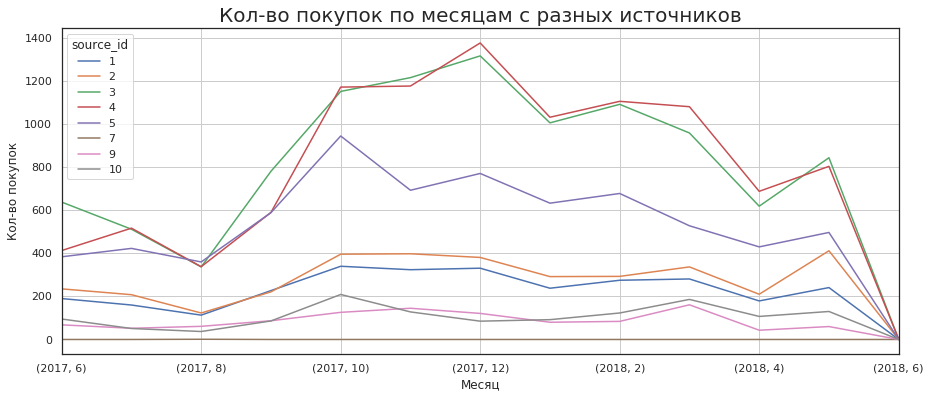

In [43]:
#Построим линейный график
buy_month_pivot.plot(figsize=(15,6), grid=True)
plt.title("Кол-во покупок по месяцам с разных источников", fontsize = 20)
plt.xlabel("Месяц", fontsize = 12)
plt.ylabel("Кол-во покупок", fontsize = 12)
plt.show()

In [44]:
#Посмотрим на характеристики столбца
payers['first_buy'].describe() 

count                   36523
unique                  34122
top       2017-11-24 17:42:00
freq                        7
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: first_buy, dtype: object

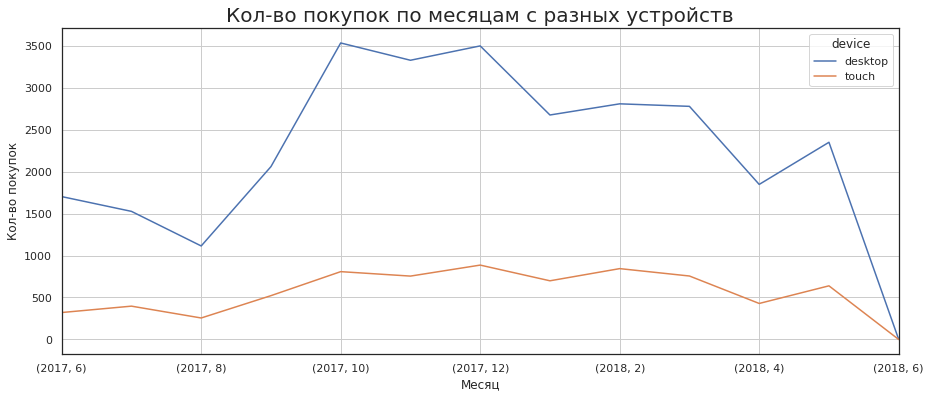

In [45]:
#Проделаем все теже действия с устрайсвами
devices = sources = visits_data.sort_values(by =['uid','start_ts']).groupby('uid').agg({'device':'first'})

payers_device = first_buy.merge(devices, on ='uid')

payers_device['buy_month'] = payers_device['first_buy'].dt.month
payers_device['buy_year'] = payers_device['first_buy'].dt.year

buy_month_device = payers_device.pivot_table(index = ['buy_year', 'buy_month'],\
                                     columns = ['device'], values = 'uid', aggfunc = 'count', fill_value=0)

buy_month_device.plot(figsize=(15,6), grid=True)
plt.title("Кол-во покупок по месяцам с разных устройств", fontsize = 20)
plt.xlabel("Месяц", fontsize = 12)
plt.ylabel("Кол-во покупок", fontsize = 12)
plt.show()

### Вывод

Мы рассчитали количество покупок в ежемесячном разрезе по каждому рекламному источнику. Декабрь самый лидирующий месяц, в нем было произведено больше всего покупок. В июне 2018 года, каждый источник на графике устремился к нулю, это связано с тем, что в данных нету информации за июнь. Последняя зафиксированная покупка была 1 июля в 00:02 ночи. 

Также как на графике с посещениями, рекламный источник № 3 и 4 главные лидеры в своем классе, показывают очень высокий рост, особенно начиная с августа 2017 года. Рекламный источник № 7 явный аутсайдер. Была всего одна продажа, в августе. Истоник № 6 вообще пропал и не показал ни одну продажу. 

Если смотреть на устройства, то покупок также как и посещений с комьютера в разы больше и динамика более острее выглядит. С помощью телефонов покупки тоже совершаются, но скромнее. Основная аудитория покупает через девайс - decktop. 

#### ШАГ 2.7. Средний чек.

In [46]:
#Добавим месяц и год всех покупок.
orders_data['buy_ts_month'] = orders_data['buy_ts'].dt.month
orders_data['buy_ts_year'] = orders_data['buy_ts'].dt.year
display(orders_data.head(10))

,buy_ts,revenue,uid,first_session,first_buy,first_buy_sec,buy_ts_month,buy_ts_year
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,60,6,2017
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,660,6,2017
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,120,6,2017
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,900,6,2017
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,1620,6,2017
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00,2017-06-01 08:43:00,0,6,2017
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:51:00,2017-06-01 08:54:00,180,6,2017
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01 08:51:00,2017-06-01 08:54:00,180,6,2017
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06-01 09:22:00,0,6,2017
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01 09:22:00,2017-06-01 09:22:00,0,6,2017


In [47]:
average_check_data = orders_data.groupby(['buy_ts_year','buy_ts_month']).agg({'revenue':'sum', 'uid':'nunique'})
average_check_data['average_check'] = round(average_check_data['revenue']/average_check_data['uid'],2)
display(average_check_data)

revenue   uid  average_check
buy_ts_year buy_ts_month                               
2017        6              9557.49  2023           4.72
            7             12539.47  1984           6.32
            8              8758.78  1472           5.95
            9             18345.51  2750           6.67
            10            27987.70  4675           5.99
            11            27069.93  4547           5.95
            12            36388.60  4942           7.36
2018        1             19417.13  3898           4.98
            2             25560.54  4258           6.00
            3             28834.59  4181           6.90
            4             16858.06  2744           6.14
            5             20735.98  3544           5.85
            6                 3.42     1           3.42

In [48]:
average_check_year = average_check_data['average_check'].mean()
print('Средний чек за год:', round(average_check_year,2))

Средний чек за год: 5.87


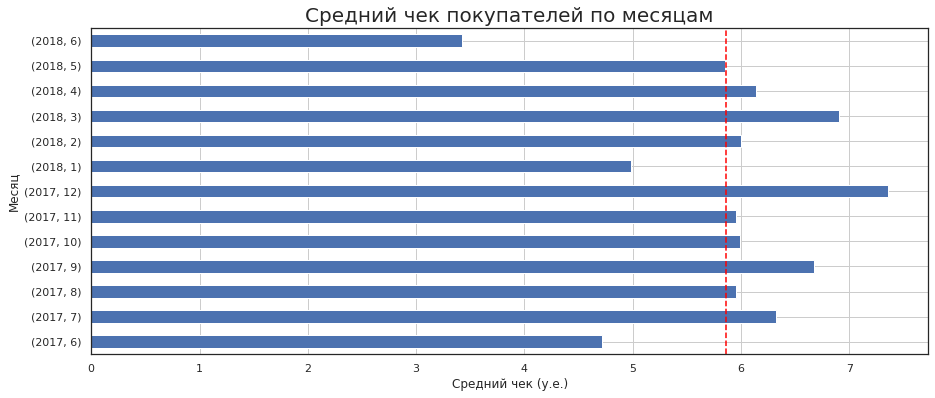

In [49]:
average_check_data['average_check'].plot(kind = 'barh', figsize=(15,6), grid=True)
plt.axvline(average_check_year, linestyle = 'dashed', color = 'red')
plt.title("Средний чек покупателей по месяцам", fontsize = 20)
plt.xlabel("Средний чек (у.е.)", fontsize = 12)
plt.ylabel("Месяц", fontsize = 12)
plt.show()

### Вывод

Мы рассчитали средний чай на каждого покупателя в ежемесячном разрезе. Средний чек за год составляет 5,87 у.е.. На графике эту планку мы обозначили красной линией, для большей наглядности. Можно сразу увидеть месяца, где средний чек был выше, среднегодового, а где ниже. Лидер из месяцев снова зимний - декабрь (средний чек 7,36у.е.). В этом месяце было также больше всего покупок, следовательно, покупок было не просто много, они были еще и самыми дорогими.

#### ШАГ 2.8. Расчет LTV. Сколько денег приносят покупатели?

In [50]:
#Соединим таблицу с первыми покупками + источники с информацией о заказах
ltv = payers.merge(orders_data, on ='uid')

#Определим время жизни когорты
ltv['lifetime'] = ((ltv['buy_ts'] - ltv['first_buy_y'])/ np.timedelta64(1,'M')).round().astype(int)

orders_liferime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'count').fillna(0)
buyers_liferime = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'uid', aggfunc = 'nunique').fillna(0)
report_ltv = ltv.pivot_table(index = 'source_id', columns = 'lifetime', values = 'revenue', aggfunc = 'sum').fillna(0)
report_ltv = report_ltv.cumsum(axis=1)

#Колличество покупателей
display(buyers_liferime)

# Накопительная выручка по месяцам
display(report_ltv)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,2899.0,110.0,92.0,59.0,57.0,39.0,45.0,33.0,23.0,14.0,15.0,10.0,6.0
2,3506.0,159.0,132.0,99.0,88.0,75.0,55.0,36.0,29.0,17.0,18.0,9.0,5.0
3,10473.0,286.0,227.0,149.0,111.0,86.0,87.0,59.0,45.0,14.0,15.0,8.0,8.0
4,10296.0,272.0,189.0,153.0,110.0,85.0,79.0,40.0,37.0,23.0,12.0,7.0,5.0
5,6931.0,175.0,124.0,79.0,79.0,59.0,47.0,34.0,25.0,19.0,7.0,6.0,2.0
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1088.0,68.0,52.0,45.0,37.0,27.0,23.0,11.0,13.0,8.0,3.0,0.0,0.0
10,1329.0,26.0,12.0,19.0,6.0,2.0,7.0,5.0,4.0,1.0,0.0,0.0,0.0


lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,17846.78,20730.27,22876.46,24750.95,26175.95,26818.89,27615.37,28604.02,29544.45,30297.05,30606.37,30942.50,31090.55
2,23737.70,28239.92,34071.03,39455.25,41721.84,43770.27,44601.29,45397.02,46178.78,46396.86,46794.56,46911.76,46923.61
3,46894.89,49529.78,50958.98,52450.34,53235.23,53648.88,53904.56,54183.84,54379.52,54433.18,54487.87,54499.75,54511.24
4,47204.71,48783.77,49959.05,50950.96,52183.86,53812.69,55004.97,55505.99,55704.86,56095.12,56655.05,56683.39,56696.83
5,34030.40,35446.46,37912.39,47385.50,49021.21,50224.35,51048.22,51670.59,52087.36,52511.13,52556.01,52622.25,52624.02
7,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22
9,4222.42,4534.12,4795.93,5090.63,5209.55,5369.92,5504.33,5577.75,5705.94,5750.05,5759.40,5759.40,5759.40
10,4205.13,4289.26,4325.49,4389.10,4407.73,4411.24,4429.19,4443.31,4446.97,4450.33,4450.33,4450.33,4450.33


In [51]:
# добавляем размеры когорт и делим на них
cohort_sizes = payers.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})

report_ltv = report_ltv.merge(cohort_sizes, on = 'source_id')

report_ltv = report_ltv.div(report_ltv['cohort_size'], axis = 0).drop(columns = 'cohort_size').round(2)
display(report_ltv)

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,6.16,7.15,7.89,8.54,9.03,9.25,9.53,9.87,10.19,10.45,10.56,10.67,10.72
2,6.77,8.05,9.72,11.25,11.90,12.48,12.72,12.95,13.17,13.23,13.35,13.38,13.38
3,4.48,4.73,4.87,5.01,5.08,5.12,5.15,5.17,5.19,5.20,5.20,5.20,5.20
4,4.58,4.74,4.85,4.95,5.07,5.23,5.34,5.39,5.41,5.45,5.50,5.51,5.51
5,4.91,5.11,5.47,6.84,7.07,7.25,7.37,7.45,7.52,7.58,7.58,7.59,7.59
7,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22,1.22
9,3.88,4.17,4.41,4.68,4.79,4.94,5.06,5.13,5.24,5.28,5.29,5.29,5.29
10,3.16,3.23,3.25,3.30,3.32,3.32,3.33,3.34,3.35,3.35,3.35,3.35,3.35


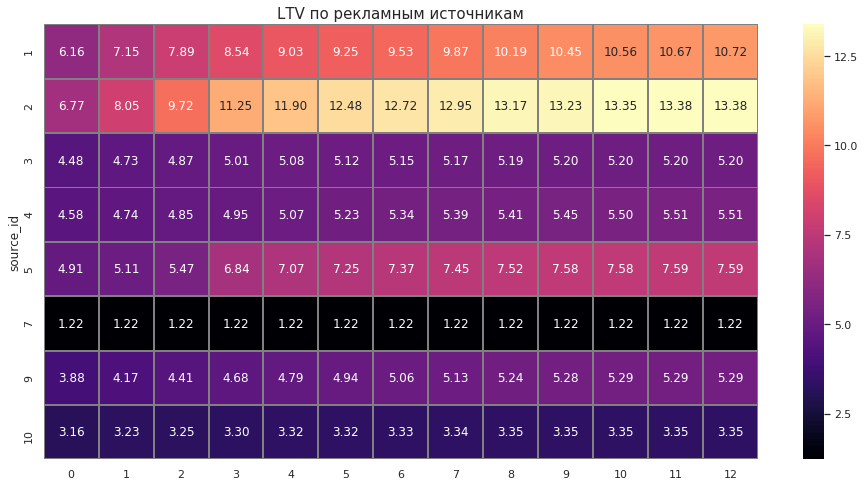

In [74]:
sns.set(style='white')
plt.figure(figsize=(16, 8))
plt.title('LTV по рекламным источникам', fontsize = 15)
sns.heatmap(report_ltv, annot=True, fmt='.2f', linewidths=1, linecolor='grey', cmap= 'magma')
plt.show()

### Вывод

Мы выяснили итоговую сумму денег, которую один клиент приносит в среднем со всех своих покупок. Временной интервал у нас месяцы, а признаки - источники рекламы. Так как маржинальность в описании задачи отсутствовала, для расчета взяли маржу 100%. 

Покупатели пришедшие из рекламных источников № 1 и 2 больше всего приносят выручки, причем они с самого первого месяца заняли лидирующие места и показывают хороший прирост с каждым новым месяцем. Истоник № 5 показывает неплохую вырочку, в приоритете он может быть интересным. Рекламный источник №7 показывает наименьшую выручку, которая не изменяется по истечению времени. Все остальные источники находятся примерно на одинаковом уровне, в середине рейтинга. 

Нужно разобраться сколько стоило привлечение одного покупателя из каждого источника и тогда сможем узнать, какие источники смогли окупить себя, не факт, что это будут 1 и 2 источник, вдруг они очень дорогие в затратах.


#### ШАГ 2.9. Сколько денег потратили? Всего / на каждый источник / по времени

In [53]:
#Добавим столбцы
costs_data['dt_year'] = costs_data['dt'].dt.year
costs_data['dt_month'] = costs_data['dt'].dt.month

In [54]:
costs = costs_data.pivot_table(index = 'source_id', columns = ['dt_year','dt_month'], values = 'costs', aggfunc = 'sum')
display(costs)

dt_year       2017                                                           \
dt_month        6        7        8        9         10        11        12   
source_id                                                                     
1          1125.61  1072.88   951.81  1502.01   2315.75   2445.16   2341.20   
2          2427.38  2333.11  1811.05  2985.66   4845.00   5247.68   4897.80   
3          7731.65  7674.37  6143.54  9963.55  15737.24  17025.34  16219.52   
4          3514.80  3529.73  3217.36  5192.26   6420.84   5388.82   7680.47   
5          2616.12  2998.14  2185.28  3849.14   5767.40   6325.34   5872.52   
9           285.22   302.54   248.93   415.62    609.41    683.18    657.98   
10          314.22   329.82   232.57   460.67    627.24    792.36    645.86   

dt_year        2018                                        
dt_month         1         2         3        4        5   
source_id                                                  
1           2186.18   2204.48   1893.09  1327.49  1467.61  
2           4157.74   4474.34   3943.14  2993.70  2689.44  
3          14808.78  14228.56  13080.85  9296.81  9411.42  
4           5832.79   5711.96   5961.87  4408.49  4214.21  
5           5371.52   5071.31   4529.62  3501.15  3669.56  
9            547.16    551.50    480.29   373.49   362.17  
10           614.35    480.88    526.41   388.25   409.86

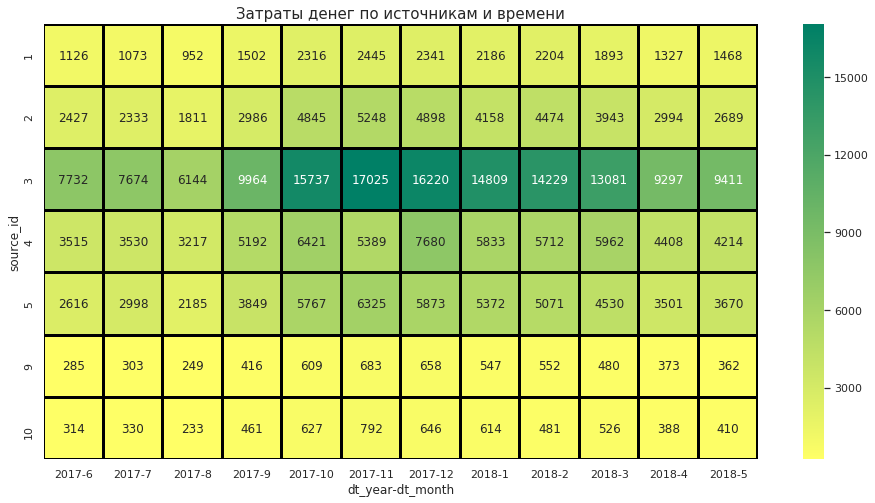

In [75]:
sns.set(style='white')
plt.figure(figsize=(16, 8))
plt.title('Затраты денег по источникам и времени', fontsize = 15)
sns.heatmap(costs, annot=True, fmt='.0f', linewidths=2, linecolor='black', cmap= 'summer_r')
plt.show()

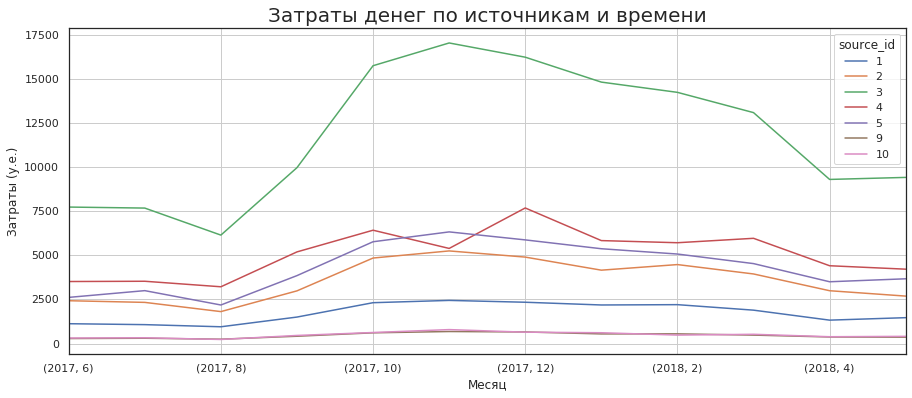

In [56]:
costs.T.plot(figsize=(15,6), grid=True)
plt.title("Затраты денег по источникам и времени", fontsize = 20)
plt.xlabel("Месяц", fontsize = 12)
plt.ylabel("Затраты (у.е.)", fontsize = 12)
plt.show()

In [57]:
#Посчитаем общую сумму затрат
costs_sum = costs_data.pivot_table(index = 'source_id', values = 'costs', aggfunc = 'sum').style\
.background_gradient(subset=['costs'], cmap ='summer_r')
display(costs_sum)



,costs
source_id,
1,20833.3
2,42806
3,141322
4,61073.6
5,51757.1
9,5517.49
10,5822.49


In [58]:
print('Всего затрат:', costs_data['costs'].sum(), 'у.е.')

Всего затрат: 329131.62 у.е.


### Вывод

Больше всего затрат уходит на источник № 3, его затраты в несколько раз превышают остальные. С источником №4 они занимали лидирующие места по посещениям и покупкам, но на источник №4 затрат меньше, нужно считать стоимость привлечения одного покупателя для полноты картины. Совокупные затраты на все источники составляют 329131.62 у.е..

Источники № 6 и 7 не имеют затрат, так как отсутствуют в таблице, но посещения по ним были, а у 7 источника даже была 1 покупка, значит возможно это заходы напрямую через поисковую систему. 


#### ШАГ 2.10. Расчет САС. Сколько стоило привлечение одного покупателя из каждого источника?

In [59]:
# считаем САС
cac = costs_data.groupby('source_id').agg({'costs': 'sum'}).merge(cohort_sizes, on = 'source_id')
cac['cac'] = round(cac['costs'] / cac['cohort_size'], 2)
display(cac)

,costs,cohort_size,cac
source_id,,,
1,20833.27,2899,7.19
2,42806.04,3506,12.21
3,141321.63,10473,13.49
4,61073.60,10296,5.93
5,51757.10,6931,7.47
9,5517.49,1088,5.07
10,5822.49,1329,4.38


In [60]:
print('Средняя стоимость одного покупателя из всех источников:', cac['cac'].mean().round(2), 'у.е.')

Средняя стоимость одного покупателя из всех источников: 7.96 у.е.


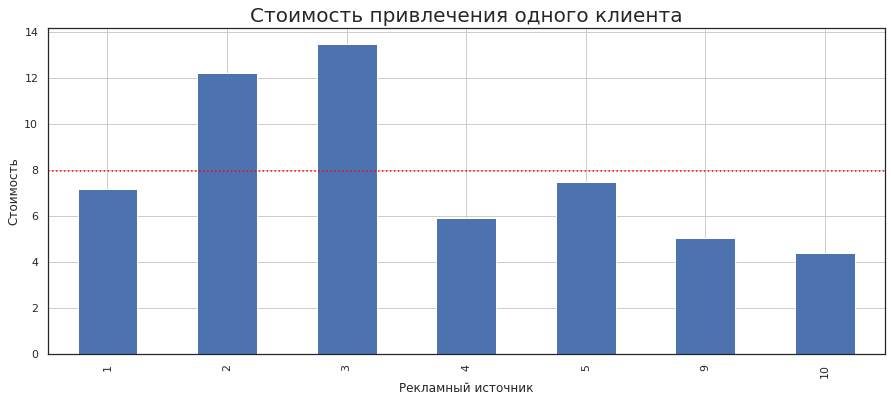

In [61]:
cac['cac'].plot(kind ='bar', figsize=(15,6), grid=True)
plt.axhline(cac['cac'].mean(), linestyle = ':', color = 'red')
plt.title("Стоимость привлечения одного клиента", fontsize = 20)
plt.xlabel("Рекламный источник", fontsize = 12)
plt.ylabel("Стоимость", fontsize = 12)
plt.show()

In [62]:
#Сделаем таблицу с месячными расходами
costs_month = costs_data.groupby(['source_id','dt_year','dt_month']).agg({'costs': 'sum'}).reset_index()\
.rename(columns = {'dt_year': 'buy_year', 'dt_month': 'buy_month'})
display(costs_month.head(5))

,source_id,buy_year,buy_month,costs
0,1,2017,6,1125.61
1,1,2017,7,1072.88
2,1,2017,8,951.81
3,1,2017,9,1502.01
4,1,2017,10,2315.75


In [63]:
#Объединим расходы с размерами когорт
cac_month = costs_month.merge(payers.groupby(['source_id','buy_year','buy_month']).agg({'uid': 'nunique'}), on =['source_id','buy_year','buy_month'])

#Считаем САС по месяцам и выводи таблицу
cac_month['cac_month'] = cac_month['costs']/cac_month['uid']
cac_month_uid = cac_month.pivot_table(index = ['buy_year','buy_month'], columns = 'source_id', values = 'cac_month', aggfunc = 'mean')
display(cac_month_uid)

source_id                 1          2          3         4         5   \
buy_year buy_month                                                       
2017     6          5.924263  10.329277  12.118574  8.510412  6.812813   
         7          6.705500  11.216875  14.989004  6.827331  7.087801   
         8          8.423097  14.723984  18.230089  9.518817  6.070222   
         9          6.616784  13.509774  12.757426  8.800441  6.535042   
         10         6.811029  12.234848  13.660799  5.478532  6.103069   
         11         7.546790  13.185126  14.001102  4.578437  9.127475   
         12         7.073112  12.855118  12.315505  5.577683  7.616757   
2018     1          9.185630  14.238836  14.720457  5.651928  8.485814   
         2          8.016291  15.270785  13.029817  5.164521  7.479808   
         3          6.736975  11.700712  13.640094  5.515143  8.578826   
         4          7.416145  14.255714  15.019079  6.407689  8.142209   
         5          6.089668   6.527767  11.150972  5.241555  7.383421   

source_id                 9         10  
buy_year buy_month                      
2017     6          4.194412  3.307579  
         7          5.818077  6.467059  
         8          4.080820  6.285676  
         9          4.777241  5.356628  
         10         4.836587  3.001148  
         11         4.711586  6.190313  
         12         5.437851  7.598353  
2018     1          6.839500  6.677717  
         2          6.565476  3.909593  
         3          2.983168  2.830161  
         4          8.685814  3.628505  
         5          6.036167  3.152769

In [64]:
cac_month_uid_total = cac_month_uid.sum(axis =1)
display(cac_month_uid_total)

buy_year  buy_month
2017      6            51.197328
          7            59.111647
          8            67.332704
          9            58.353337
          10           52.126013
          11           59.340828
          12           58.474380
2018      1            65.799882
          2            59.436291
          3            51.985079
          4            63.555156
          5            45.582318
dtype: float64

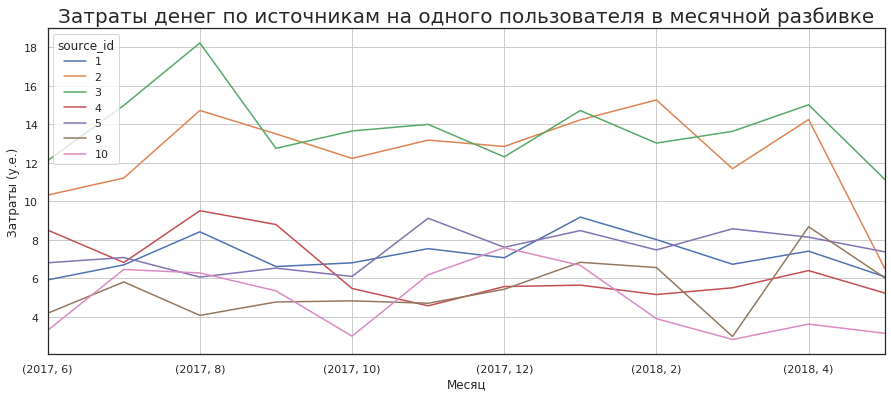

In [65]:
cac_month_uid.plot(figsize=(15,6), grid=True)
plt.title("Затраты денег по источникам на одного пользователя в месячной разбивке", fontsize = 20)
plt.xlabel("Месяц", fontsize = 12)
plt.ylabel("Затраты (у.е.)", fontsize = 12)
plt.show()

### Вывод

Мы рассчитали САС, то есть стоимость привлечения клиента, сумму денег, во сколько обходится новый клиент компании. Разбили метрику по рекламным источникам. В итоге источник №3 подтвердил, то, что он является самым затратрным на одного клиента, в районе 13.5 у.е. Также высокий САС и у второго источника - 12,21 у.е. Менее затратные источники у нас №4, 9 и 10 менее 6 у.е. на клиента. Самое время разобраться, насколько окупились расходы компании, для этого нужно смотреть на ROI. 

Если смотреть на затраты ежемесячные, то самые крупные затраты были в августе 2017 года, самые малые затраты в мае 2018.

#### ШАГ 2.11. На сколько окупились расходы? Расчет ROI.

In [66]:
# считаем ROI
roi = report_ltv.merge(cac[['cac']], on = 'source_id')
roi = roi.div(roi['cac'], axis = 0).drop(columns = 'cac')
display(roi)

,0,1,2,3,4,5,6,7,8,9,10,11,12
source_id,,,,,,,,,,,,,
1,0.856745,0.994437,1.097357,1.187761,1.255911,1.286509,1.325452,1.372740,1.417246,1.453408,1.468707,1.484006,1.490960
2,0.554464,0.659296,0.796069,0.921376,0.974611,1.022113,1.041769,1.060606,1.078624,1.083538,1.093366,1.095823,1.095823
3,0.332098,0.350630,0.361008,0.371386,0.376575,0.379540,0.381764,0.383247,0.384729,0.385471,0.385471,0.385471,0.385471
4,0.772344,0.799325,0.817875,0.834739,0.854975,0.881956,0.900506,0.908938,0.912310,0.919056,0.927487,0.929174,0.929174
5,0.657296,0.684070,0.732262,0.915663,0.946452,0.970549,0.986613,0.997323,1.006693,1.014726,1.014726,1.016064,1.016064
9,0.765286,0.822485,0.869822,0.923077,0.944773,0.974359,0.998028,1.011834,1.033531,1.041420,1.043393,1.043393,1.043393
10,0.721461,0.737443,0.742009,0.753425,0.757991,0.757991,0.760274,0.762557,0.764840,0.764840,0.764840,0.764840,0.764840


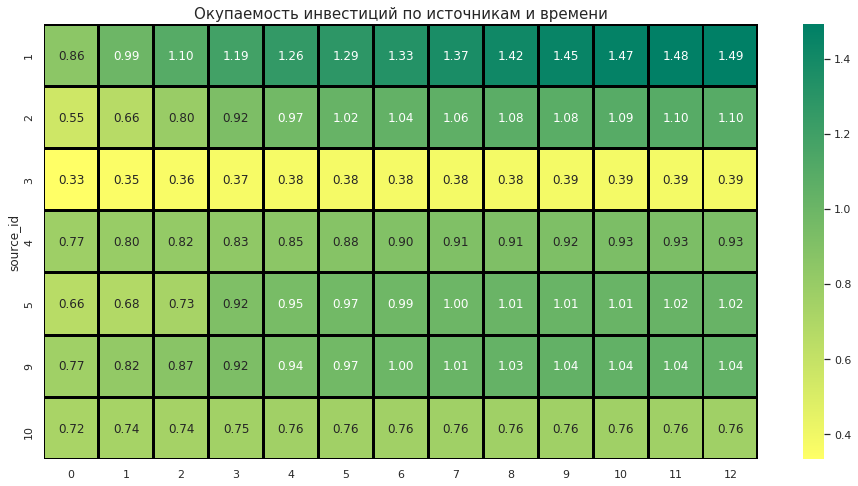

In [76]:
sns.set(style='white')
plt.figure(figsize=(16, 8))
plt.title('Окупаемость инвестиций по источникам и времени', fontsize = 15)
sns.heatmap(roi, annot=True, fmt='.2f', linewidths=2, linecolor='black', cmap= 'summer_r')
plt.show()

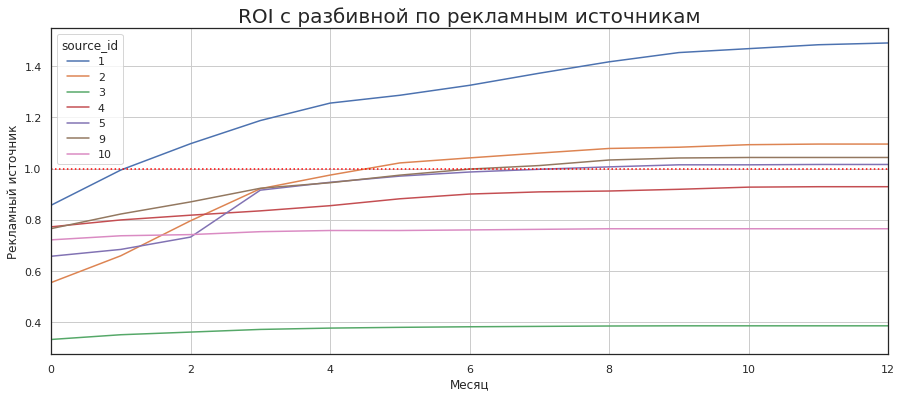

In [68]:
#Построим линейный график
roi.T.plot(figsize=(15,6), grid=True)
plt.axhline(1, linestyle = ':', color = 'red')
plt.title("ROI с разбивной по рекламным источникам", fontsize = 20)
plt.xlabel("Месяц", fontsize = 12)
plt.ylabel("Рекламный источник", fontsize = 12)
plt.show()

### Вывод

Мы рассчитали ROI - узнали окупаемость вложенных денег. Видно, что 1-й источник пересек уровень окупаемости почти сразу, источники 2,5 и 9 задержались на полгода, остальные вообще не окупились и врятли окупяться так как на графике заняли горизонтальное положение. 


### Общий вывод

Мы проделали большой анализ и рассчитали множество метрик для оптимизации маркетинговых затрат. По ходу нашей работы, мнения о разных источниках менялись и становились все более актуальными и прозрачными, даем отделу маркетинга и менеджменту следующие рекомендации и выводы:

1) Основная аудитория клиентов (посещения и покупки) происходят с компьютера, стоит проверить мобильную версию сайта или приложения, возможно, в них есть какие-то недочеты и людям из-за этого менее удобно пользоваться данным устройством. 

2) Рекламные источники: 

- Рекламный источник № 1: Является самым быстро окупаемым источником из всех предоставленных. У него небольшие затраты, но при этом каждый клиент из этого источника, приносит большую выручку компании. К сожалению посещений, и покупок через этот источник немного, советую, как можно быстрее повысить посещаемость через него, это приведет к быстрому росту финансовых показателей компании.


- Рекламные источник № 2 и № 9: Смогли окупиться спустя полгода, это интересные источники для развития. По источнику № 2 имеется достаточно высокие затраты на одного клиента, но так как показатели по метрике LTV являются наилучшими, данный источник смог себя окупить через полгода и начал приносить прибыль компании. У канала привлечения № 9 противоположная ситуация, он имеет минимальные затраты, но и LTV невысок. Но ROI у обоих неплохие.  По данным источникам также совсем мало было посещений и покупок. На них также стоит обратить внимания и начать привлекать как можно больше клиентов через данные способы. 


- Рекламный источник № 5: Является привлекательным за счет окупаемости за полгода. При этом он занимает почетное 3-е место по посещаемости и покупкам клиентами. Следовательно, этим источник чаще пользуются и его знает большая аудитория и будет легче развивать данный канал привлечения. Источник однозначно интересен бизнесу. 

Теперь поговорим о грустном.

- Рекламные источник № 3 и 4: через эти источники проходит самое большое количество клиентов и совершают самое большое количество покупок. LTV по ним не высокое, значит каждый клиент приносит не очень много выручки в компанию. При этом затраты на 3 источник зашкаливают, в итоге данные каналы привлечения не смогли себя окупить в течении года и врятли уже окупят. Канал привлечения № 4 еще можно спасти, так как затраты в нем небольшие на каждого клиента, нужно подумать, как увеличить средний чек. Рекламный источник № 3 крайне неблагоприятный и убыточный, его скорее всего стоит закрыть.

- Рекламный источник № 6 и 7 не имеют затрат, но и посещений по ним было крайне мало. Что касается покупок, то по 6 источнику покупки отсутствуют, по 7 источнику была всего одна покупка. Так как затрат нету, то предполагается, что это прямой заход клиента через поисковую систему. Советую работать над узнаваемостью бренда и сервиса, что бы, как можно у большего количества людей это было на слуху.

Также в дополнение хочется сказать, что в холодное время года, продажи растут, в теплое падают, это связано скорее не от работы сервиса, а от интересов и настроения клиентов. 
